### Imports

In [33]:
import os
import joblib
import numpy as np
import pandas as pd
import importlib
import re
import yaml

import sklearn.ensemble 
import sklearn.model_selection
import sklearn.inspection
import sklearn.metrics

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [73]:
# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\221029_random_forest\plots"

# Directory: sklearn
dirs_sklearn = [
    r"C:\Data\lwf\analysis\221029_random_forest\sklearn\v01\2020",
    r"C:\Data\lwf\analysis\221029_random_forest\sklearn\v01\2021",
]

# Save names:
load_name_params = 'params.yaml'
load_name_gridcv = 'grid.joblib'
load_name_dataset = 'dataset.joblib'
# load_name_permutation_test_score = 'permutation_test_score.joblib'
# load_name_permutation_feature_importance = 'permutation_feature_importance.joblib'

### Load

#### Load: Pre-computed dataset and sklearn results

In [74]:
datasets = []
grds = []
params = []

for dir_sklearn in dirs_sklearn:

    # Load dataset & sklearn results
    datasets.append(joblib.load(os.path.join(dir_sklearn, load_name_dataset)))
    grds.append(joblib.load(os.path.join(dir_sklearn, load_name_gridcv)))
    # permutation_test_score = joblib.load(os.path.join(dir_sklearn, load_name_permutation_test_score))
    # permutation_feature_importance = joblib.load(os.path.join(dir_sklearn, load_name_permutation_feature_importance))

    # Load params
    with open(os.path.join(dir_sklearn, load_name_params), "r") as f:
        params.append(yaml.safe_load(f))

### 2021

#### 2021_v01: Conifers vs. Broadleaf

##### 2021_v01: Load & Overview

In [100]:
#### Load classifier and dataset
i_grd = 1
i_data = 1

grd = grds[i_grd]
dataset = datasets[i_data]
param_grd = params[i_grd]
param_data = params[i_data]

x = dataset['x_test'].copy()
y = dataset['y_test'].copy()
y_extend_names = dataset['y_extend_names'].copy()
y_extend = dataset['y_extend_test'].copy()

# Prediction probalities
y_pred = grd.best_estimator_.predict(x)
y_pred_proba = grd.best_estimator_.predict_proba(x)


#### Overview
print(f"Grid Search Cross Validation: Best estimator")
print('-'*50)
print(f"{'Params:':<20}{grd.best_params_}")
print(f"{'Validation score:':<20}{grd.best_score_:.2f}")
print(f"{'Test score:':<20}{grd.best_estimator_.score(x, y):.2f}")
print(f"{'Shape of training features:':<30}{datasets[i_grd]['x_train'].shape}")
print(f"{'Shape of test features:':<30}{x.shape}")


cv_results = pd.DataFrame(grd.cv_results_)
cv_results.drop(columns=['params'], inplace=True)

Grid Search Cross Validation: Best estimator
--------------------------------------------------
Params:             {'criterion': 'entropy', 'max_samples': 0.75, 'min_samples_leaf': 1, 'n_estimators': 100}
Validation score:   0.97
Test score:         0.96
Shape of training features:   (2877, 107)
Shape of test features:       (960, 107)


##### 2021_v01: Confusion matrix

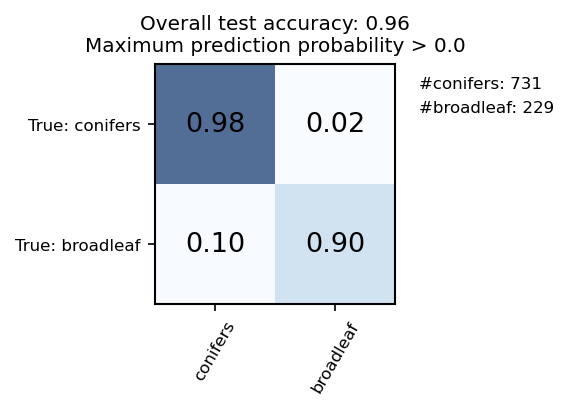

In [101]:
# Select samples based on max.prediction probability threshold
proba_thresh = 0.

select = np.max(y_pred_proba, axis=1) > proba_thresh
y_reduce = y[select]
y_pred_reduce = y_pred[select]

# Compute diffusion matrices
confusion_matrix = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce, normalize='true')


# Plotting
f = plt.figure(figsize=[4,4])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.3, right=0.7)
ax = f.add_subplot(111)

ticks = range(len(confusion_matrix))

ax.imshow(
    confusion_matrix,
    cmap='Blues',
    alpha=0.7,
)

for xtick in ticks:
    for ytick in ticks:
        ax.text(ytick, xtick, f"{confusion_matrix_norm[xtick,ytick]:.2f}", ha='center', va='center', fontsize=13)
 
ax.set_title(
    f"Overall test accuracy: {grd.best_estimator_.score(x, y):.2f}\n" +
    f"Maximum prediction probability > {proba_thresh:.1f}"
)

ax.set_xticks(ticks)
ax.set_xticklabels([param_grd['labels'][tick] for tick in ticks], rotation=60)
ax.set_yticks(ticks)
ax.set_yticklabels(['True: ' + param_grd['labels'][tick] for tick in ticks], rotation=0)

for label, name in param_grd['labels'].items():
    ax.text(
        1.7,
        -0.3 + 0.2 * label,
        f"#{name}: {np.sum(y_reduce == label)}",
    )


save_name = f"2021_rf_v01_confusion_p{proba_thresh*100:.0f}" + '.pdf'
plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

### 2020

#### 2020_v01: Conifers vs. Broadleaf

##### 2020_v01: Load & Overview

In [102]:
#### Load classifier and dataset
i_grd = 0
i_data = 0

grd = grds[i_grd]
dataset = datasets[i_data]
param_grd = params[i_grd]
param_data = params[i_data]

x = dataset['x_test'].copy()
y = dataset['y_test'].copy()
y_extend_names = dataset['y_extend_names'].copy()
y_extend = dataset['y_extend_test'].copy()

# Prediction probalities
y_pred = grd.best_estimator_.predict(x)
y_pred_proba = grd.best_estimator_.predict_proba(x)


#### Overview
print(f"Grid Search Cross Validation: Best estimator")
print('-'*50)
print(f"{'Params:':<20}{grd.best_params_}")
print(f"{'Validation score:':<20}{grd.best_score_:.2f}")
print(f"{'Test score:':<20}{grd.best_estimator_.score(x, y):.2f}")
print(f"{'Shape of training features:':<30}{datasets[i_grd]['x_train'].shape}")
print(f"{'Shape of test features:':<30}{x.shape}")


cv_results = pd.DataFrame(grd.cv_results_)
cv_results.drop(columns=['params'], inplace=True)

Grid Search Cross Validation: Best estimator
--------------------------------------------------
Params:             {'criterion': 'gini', 'max_samples': 0.75, 'min_samples_leaf': 1, 'n_estimators': 200}
Validation score:   0.93
Test score:         0.95
Shape of training features:   (3021, 107)
Shape of test features:       (1008, 107)


##### 2020_v01: Confusion matrix

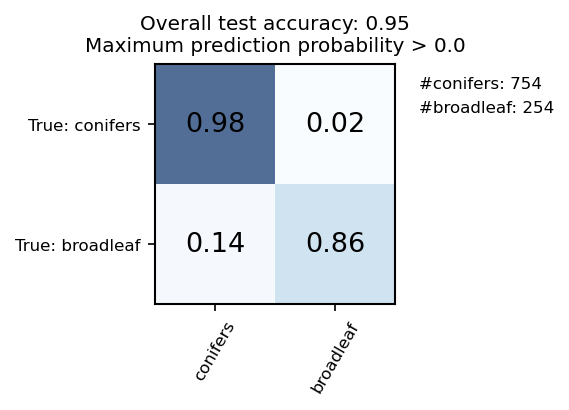

In [105]:
# Select samples based on max.prediction probability threshold
proba_thresh = 0.

select = np.max(y_pred_proba, axis=1) > proba_thresh
y_reduce = y[select]
y_pred_reduce = y_pred[select]

# Compute diffusion matrices
confusion_matrix = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce, normalize='true')


# Plotting
f = plt.figure(figsize=[4,4])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.3, right=0.7)
ax = f.add_subplot(111)

ticks = range(len(confusion_matrix))

ax.imshow(
    confusion_matrix,
    cmap='Blues',
    alpha=0.7,
)

for xtick in ticks:
    for ytick in ticks:
        ax.text(ytick, xtick, f"{confusion_matrix_norm[xtick,ytick]:.2f}", ha='center', va='center', fontsize=13)
 
ax.set_title(
    f"Overall test accuracy: {grd.best_estimator_.score(x, y):.2f}\n" +
    f"Maximum prediction probability > {proba_thresh:.1f}"
)

ax.set_xticks(ticks)
ax.set_xticklabels([param_grd['labels'][tick] for tick in ticks], rotation=60)
ax.set_yticks(ticks)
ax.set_yticklabels(['True: ' + param_grd['labels'][tick] for tick in ticks], rotation=0)

for label, name in param_grd['labels'].items():
    ax.text(
        1.7,
        -0.3 + 0.2 * label,
        f"#{name}: {np.sum(y_reduce == label)}",
    )


save_name = f"2020_rf_v01_confusion_p{proba_thresh*100:.0f}" + '.pdf'
plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

### 2021on2020

#### 2021on2020_v01: Conifers vs. Broadleaf

##### 2021on2020_v01: Load & Overview

In [114]:
#### Load classifier and dataset
i_grd = 1
i_data = 0

grd = grds[i_grd]
dataset = datasets[i_data]
param_grd = params[i_grd]
param_data = params[i_data]

# Complete 2020 dataset for testing!!
x = np.concatenate([dataset['x_train'].copy(), dataset['x_test'].copy()] )
y = np.concatenate([dataset['y_train'].copy(), dataset['y_test'].copy()] ) 
y_extend_names = dataset['y_extend_names'].copy()
y_extend = np.concatenate([dataset['y_extend_train'].copy(), dataset['y_extend_test'].copy()] )

# Prediction probalities
y_pred = grd.best_estimator_.predict(x)
y_pred_proba = grd.best_estimator_.predict_proba(x)


#### Overview
print(f"Grid Search Cross Validation: Best estimator")
print('-'*50)
print(f"{'Params:':<20}{grd.best_params_}")
print(f"{'Validation score:':<20}{grd.best_score_:.2f}")
print(f"{'Test score:':<20}{grd.best_estimator_.score(x, y):.2f}")
print(f"{'Shape of training features:':<30}{datasets[i_grd]['x_train'].shape}")
print(f"{'Shape of test features:':<30}{x.shape}")


cv_results = pd.DataFrame(grd.cv_results_)
cv_results.drop(columns=['params'], inplace=True)

Grid Search Cross Validation: Best estimator
--------------------------------------------------
Params:             {'criterion': 'entropy', 'max_samples': 0.75, 'min_samples_leaf': 1, 'n_estimators': 100}
Validation score:   0.97
Test score:         0.87
Shape of training features:   (2877, 107)
Shape of test features:       (4029, 107)


##### 2021on2020_v01: Confusion matrix

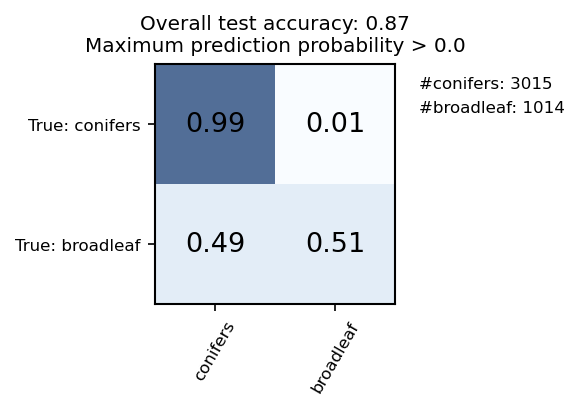

In [115]:
# Select samples based on max.prediction probability threshold
proba_thresh = 0.

select = np.max(y_pred_proba, axis=1) > proba_thresh
y_reduce = y[select]
y_pred_reduce = y_pred[select]

# Compute diffusion matrices
confusion_matrix = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce, normalize='true')


# Plotting
f = plt.figure(figsize=[4,4])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.3, right=0.7)
ax = f.add_subplot(111)

ticks = range(len(confusion_matrix))

ax.imshow(
    confusion_matrix,
    cmap='Blues',
    alpha=0.7,
)

for xtick in ticks:
    for ytick in ticks:
        ax.text(ytick, xtick, f"{confusion_matrix_norm[xtick,ytick]:.2f}", ha='center', va='center', fontsize=13)
 
ax.set_title(
    f"Overall test accuracy: {grd.best_estimator_.score(x, y):.2f}\n" +
    f"Maximum prediction probability > {proba_thresh:.1f}"
)

ax.set_xticks(ticks)
ax.set_xticklabels([param_grd['labels'][tick] for tick in ticks], rotation=60)
ax.set_yticks(ticks)
ax.set_yticklabels(['True: ' + param_grd['labels'][tick] for tick in ticks], rotation=0)

for label, name in param_grd['labels'].items():
    ax.text(
        1.7,
        -0.3 + 0.2 * label,
        f"#{name}: {np.sum(y_reduce == label)}",
    )


save_name = f"2021on2020_rf_v01_confusion_p{proba_thresh*100:.0f}" + '.pdf'
plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

### 2020on2021

#### 2020on2021_v01: Conifers vs. Broadleaf

##### 2020on2021_v01: Load & Overview

In [116]:
#### Load classifier and dataset
i_grd = 0
i_data = 1

grd = grds[i_grd]
dataset = datasets[i_data]
param_grd = params[i_grd]
param_data = params[i_data]

# Complete 2021 dataset for testing!!
x = np.concatenate([dataset['x_train'].copy(), dataset['x_test'].copy()] )
y = np.concatenate([dataset['y_train'].copy(), dataset['y_test'].copy()] )
y_extend_names = dataset['y_extend_names'].copy()
y_extend = np.concatenate([dataset['y_extend_train'].copy(), dataset['y_extend_test'].copy()] )

# Prediction probalities
y_pred = grd.best_estimator_.predict(x)
y_pred_proba = grd.best_estimator_.predict_proba(x)

#### Overview
print(f"Grid Search Cross Validation: Best estimator")
print('-'*50)
print(f"{'Params:':<20}{grd.best_params_}")
print(f"{'Validation score:':<20}{grd.best_score_:.2f}")
print(f"{'Test score:':<20}{grd.best_estimator_.score(x, y):.2f}")
print(f"{'Shape of training features:':<30}{datasets[i_grd]['x_train'].shape}")
print(f"{'Shape of test features:':<30}{x.shape}")


cv_results = pd.DataFrame(grd.cv_results_)
cv_results.drop(columns=['params'], inplace=True)

Grid Search Cross Validation: Best estimator
--------------------------------------------------
Params:             {'criterion': 'gini', 'max_samples': 0.75, 'min_samples_leaf': 1, 'n_estimators': 200}
Validation score:   0.93
Test score:         0.94
Shape of training features:   (3021, 107)
Shape of test features:       (3837, 107)


##### 2020on2021_v01: Confusion matrix

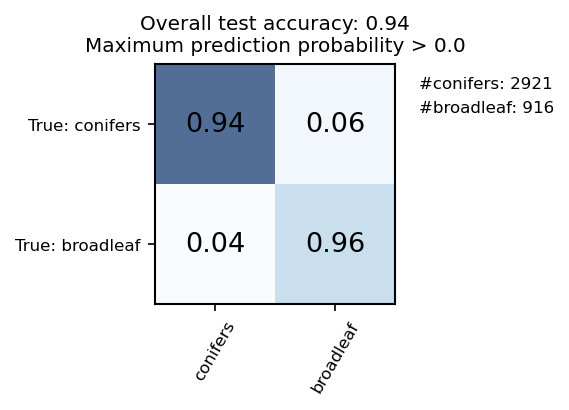

In [117]:
# Select samples based on max.prediction probability threshold
proba_thresh = 0.

select = np.max(y_pred_proba, axis=1) > proba_thresh
y_reduce = y[select]
y_pred_reduce = y_pred[select]

# Compute diffusion matrices
confusion_matrix = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce)
confusion_matrix_norm = sklearn.metrics.confusion_matrix(y_reduce, y_pred_reduce, normalize='true')


# Plotting
f = plt.figure(figsize=[4,4])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.3, right=0.7)
ax = f.add_subplot(111)

ticks = range(len(confusion_matrix))

ax.imshow(
    confusion_matrix,
    cmap='Blues',
    alpha=0.7,
)

for xtick in ticks:
    for ytick in ticks:
        ax.text(ytick, xtick, f"{confusion_matrix_norm[xtick,ytick]:.2f}", ha='center', va='center', fontsize=13)
 
ax.set_title(
    f"Overall test accuracy: {grd.best_estimator_.score(x, y):.2f}\n" +
    f"Maximum prediction probability > {proba_thresh:.1f}"
)

ax.set_xticks(ticks)
ax.set_xticklabels([param_grd['labels'][tick] for tick in ticks], rotation=60)
ax.set_yticks(ticks)
ax.set_yticklabels(['True: ' + param_grd['labels'][tick] for tick in ticks], rotation=0)

for label, name in param_grd['labels'].items():
    ax.text(
        1.7,
        -0.3 + 0.2 * label,
        f"#{name}: {np.sum(y_reduce == label)}",
    )


save_name = f"2020on2021_rf_v01_confusion_p{proba_thresh*100:.0f}" + '.pdf'
plt.savefig(os.path.join(dir_plots, save_name), transparent=True)